# NNet class in Pytorch

In this assignment you will complete an implementation of a neural network class that uses `pytorch`.  You will then use it to conduct some training experiments on specified data.  The data will be partitioned into some number of non-intersecting folds.  You will train, validate and test neural networks of various sizes on all ways of picking one fold to be testing, one fold to be validation, and remaining folds to be training sets.

## Implementation

In [ ]:
import numpy as np
import torch
import pandas
import matplotlib.pyplot as plt

Complete the following definition of class `NNet` by completing its `train` function.

In [ ]:
class NNet(torch.nn.Module):
    
    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, act_func='tanh'):
        super().__init__()  # call parent class (torch.nn.Module) constructor
        
        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        self.hidden_layers = torch.nn.ModuleList()  # necessary for model.to('cuda')

        for nh in self.n_hiddens_per_layer:
            self.hidden_layers.append( torch.nn.Sequential(
                torch.nn.Linear(n_inputs, nh),
                torch.nn.Tanh() if act_func == 'tanh' else torch.nn.ReLU()))
            
            n_inputs = nh

        self.output_layer = torch.nn.Linear(n_inputs, n_outputs)
            
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None

        self.error_trace = []
        
    def forward(self, X):
        Y = X
        for hidden_layer in self.hidden_layers:
            Y = hidden_layer(Y)
        Y = self.output_layer(Y)
        return Y

    def train(self, X, T, n_epochs, learning_rate, verbose=True):

        # Set data matrices to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()
        if not isinstance(T, torch.Tensor):
            T = torch.from_numpy(T).float()
            
        # Calculate standardization parameters if not already calculated
        if self.Xmeans is None:
            self.Xmeans = X.mean(0)
            self.Xstds = X.std(0)
            self.Xstds[self.Xstds == 0] = 1
            self.Tmeans = T.mean(0)
            self.Tstds = T.std(0)
            self.Tstds[self.Tstds == 0] = 1
            
        # Standardize inputs and targets
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds
        
        # Set optimizer to Adam and loss functions to MSELoss
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        mse_func = torch.nn.MSELoss()

        # For each epoch:
        # DONE  Do forward pass to calculate output Y.
        # DONE  Calculate mean squared error loss, mse.
        # DONE  Calculate gradient of mse with respect to all weights by calling mse.backward().
        # DONE  Take weight update step, then zero the gradient values.
        # =====TODO=====  Unstandardize the mse error and save in self.error_trace
        # DONE  Print epoch+1 and unstandardized error if verbose is True and
        #             (epoch+1 is n_epochs or epoch+1 % (n_epochs // 10) == 0)
        
        for epoch in range(n_epochs):
            Y = self.forward(X)
    
            mse = mse_func(T, Y)
            mse.backward()
    
            optimizer.step() 
            optimizer.zero_grad()
            
            mse_unstd = (np.sqrt(mse.cpu().detach().numpy()) * self.Tstds).cpu().numpy().item()
            self.error_trace.append(mse_unstd)
            
            if verbose and ((epoch + 1 is n_epochs) or ((epoch + 1) % (n_epochs // 10) == 0)):
                print(f'Epoch {epoch + 1}: RMSE {mse_unstd:.3f}')

    def use(self, X):
 
       # Set input matrix to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()

        # DONE Standardize X
        X = (X - self.Xmeans) / self.Xstds
        
        # DONE Do forward pass and unstandardize resulting output. Assign to variable Y.
        forward_pass = self.forward(X)
        Y = forward_pass * self.Tstds + self.Tmeans
        
        # Return output Y after detaching from computation graph and converting to numpy
        return Y.detach().cpu().numpy()

## Example

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
    
n_samples = 10000
X = np.linspace(0, 10, n_samples).reshape((-1, 1))
T = X ** 2

n_samples, n_inputs = X.shape 
n_outputs = T.shape[1]

n_hiddens = [100, 100]
net = NNet(n_inputs, n_hiddens, n_outputs, act_func='relu')
net.train(X, T, 50, 0.01)
Y = net.use(X)

def rmse(Y, T):
    return np.sqrt(np.mean((T - Y)**2))

print(f'RMSE {rmse(Y, T):.3f}')

Epoch 5: RMSE 11.155
Epoch 10: RMSE 6.062
Epoch 15: RMSE 5.169
Epoch 20: RMSE 2.103
Epoch 25: RMSE 2.317
Epoch 30: RMSE 2.636
Epoch 35: RMSE 1.463
Epoch 40: RMSE 1.137
Epoch 45: RMSE 1.170
Epoch 50: RMSE 0.922
RMSE 0.867


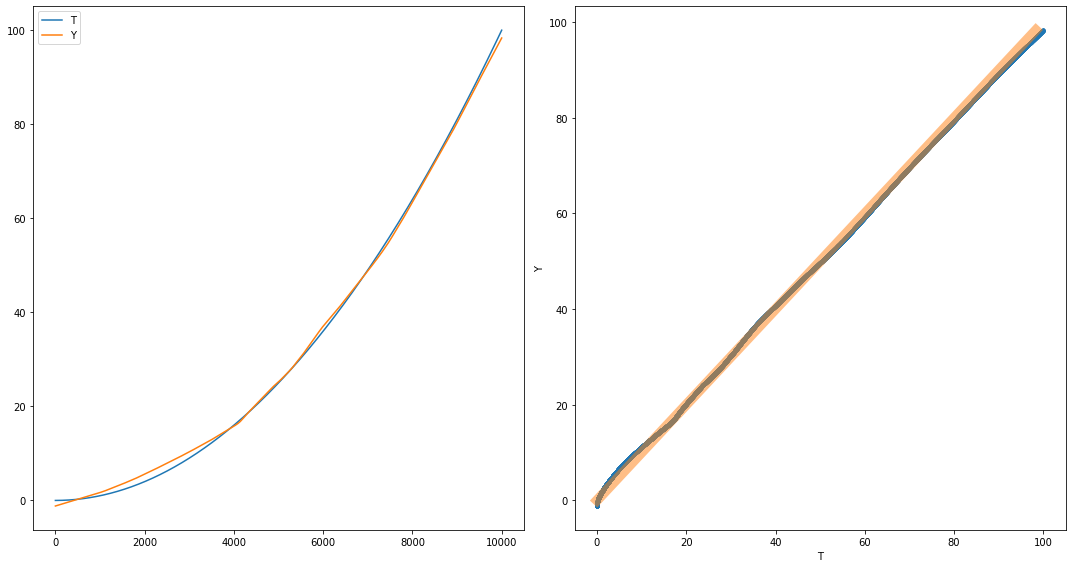

In [ ]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.plot(T, label='T')
plt.plot(Y, label='Y')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(T, Y, '.')
a = max(np.min(T), np.min(Y))
b = min(np.max(T), np.max(Y))
plt.plot([a, b], [a, b], lw=10, alpha=0.5)
plt.xlabel('T')
plt.ylabel('Y')
plt.tight_layout()

# Function to generate all train, validate, and test partitions given number of folds

## Implementation

This is complete code for `generate_k_fold_cross_validation_sets`.

In [ ]:
def generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):

    if shuffle:
        # Randomly order X and T
        randorder = np.arange(X.shape[0])
        np.random.shuffle(randorder)
        X = X[randorder, :]
        T = T[randorder, :]

    # Partition X and T into folds
    n_samples = X.shape[0]
    n_per_fold = round(n_samples / n_folds)
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )

    # Yield k(k-1) assignments of Xtrain, Train, Xvalidate, Tvalidate, Xtest, Ttest

    for validation_i in range(n_folds):
        for test_i in range(n_folds):
            if test_i == validation_i:
                continue

            train_i = np.setdiff1d(range(n_folds), [validation_i, test_i])

            Xvalidate, Tvalidate = folds[validation_i]
            Xtest, Ttest = folds[test_i]
            if len(train_i) > 1:
                Xtrain = np.vstack([folds[i][0] for i in train_i])
                Ttrain = np.vstack([folds[i][1] for i in train_i])
            else:
                Xtrain, Ttrain = folds[train_i[0]]

            yield Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

## Example

In [ ]:
X = np.arange(2 * 6).reshape((6, 2))
T = np.arange(6).reshape((6, 1)) * 10
X, T

(array([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]]), array([[ 0],
        [10],
        [20],
        [30],
        [40],
        [50]]))

In [ ]:
np.random.seed(42)

for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, 3):
    print()
    print('Xtrain\n', Xtrain)
    print('Ttrain\n', Ttrain)
    print('Xvalidate\n', Xvalidate)
    print('Tvalidate\n', Tvalidate)
    print('Xtest\n', Xtest)
    print('Ttest\n', Ttest)
    


Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]


# Function to train NNets and average RMSE over all ways of partitioning

## Implementation

Define the following function that trains neural networks of different architectures, given by `list_of_n_hiddens`, for one value each of `n_epochs`, `learning_rate`, and `act_fun`.  For each network, train on all k-fold cross-validation training sets, and calculate the RMSEs for the training, validation and test. Calculate the mean of training, validation and test RMSEs over the k-fold partitions, so that you have one training, one validation, and one test set RMSE for each network.  Append a list of the architecture and these three mean RMSEs to a list of results and return the list as a pandas DataFrame described below when done.

To iterate over all k-fold partitions, use a for loop like the example in the previous code cell. Call `generate_k_fold_cross_validation_sets` with `shuffle=True`. 

In [ ]:
def run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens, 
                                n_epochs, learning_rate, act_func):
    n_samples, n_inputs = X.shape
    n_outputs = T.shape[1]
    
    # Initialize the list for aggregating results
    results_list = []
    
    # Iterate over network architectures given by list_of_n_hiddens
    for network in list_of_n_hiddens:
        total_train_rmse, total_validate_rmse, total_test_rmse, total_training_sets = 0, 0, 0, 0
        
        # For each network, train on all k=fold cross-validation training sets
        for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, n_folds):
            # Increment for mean RMSE calculation later
            total_training_sets += 1
            
            # Run the netowkr with the given architecture and train on the given training set
            net = NNet(n_inputs, network, n_outputs, act_func)
            net.train(Xtrain, Ttrain, n_epochs, learning_rate, False)
            
            # Calculate RMSE values for the current network/cross-validation combination
            use_train = net.use(Xtrain)
            use_validate = net.use(Xvalidate)
            use_test = net.use(Xtest)
            rmse_train = np.sqrt(np.mean((Ttrain - use_train)**2)).item()
            total_train_rmse += rmse_train
            rmse_validate = np.sqrt(np.mean((Tvalidate - use_validate)**2)).item()
            total_validate_rmse += rmse_validate
            rmse_test = np.sqrt(np.mean((Ttest - use_test)**2)).item()
            total_test_rmse += rmse_test
        
        mean_train_rmse = total_train_rmse / total_training_sets
        mean_validate_rmse = total_validate_rmse / total_training_sets
        mean_test_rmse = total_test_rmse / total_training_sets
        
        # Add this network's mean RMSEs to the list
        new_row = (network, mean_train_rmse, mean_validate_rmse, mean_test_rmse)
        results_list.append(new_row)

    # Add all results to a DataFrame
    column_names = ['Arch', 'Training RMSE', 'Validate RMSE', 'Test RMSE']
    df = pandas.DataFrame(results_list, columns = column_names)
    
    return df

## Apply to Airfoil Data

Download `airfoil_self_noise.dat` from [Airfoil Data Website](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise) and read it as shown below.

In [ ]:
!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat
airfoil = pandas.read_csv('airfoil_self_noise.dat', delimiter='\t',
                          names=('frequency', 'angle', 'chord', 
                                 'velocity', 'thickness', 'pressure'))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 59984  100 59984    0     0   254k      0 --:--:-- --:--:-- --:--:--  254k


Apply your `run_k_fold_cross_validation` to the airfoil data, with `X` being the first five columns of the data and `T` being the last column, the 'pressure'. 

Here is an example run.  You must try more neural network architectures.  Keep the following points in mind when you choose parameter values to try:
* Larger networks will require more epochs of training to converge.
* Large learning rates could limit convergence, but small learning rates may take many more epochs than you have patience for.
* Display results as a `pandas` `DataFrame` and in plots.  <font color=red>Your tabular results and plots must be described with at least 10 sentences.</font>
* Name the columns of your `DataFrame` result to be `columns=('Arch', 'Train RMSE', 'Validate RMSE', 'Test RMSE'))`

In [ ]:
X = airfoil.iloc[:,:-1].to_numpy()
T = airfoil.iloc[:,-1:].to_numpy()

In [ ]:
X.shape, T.shape

((1503, 5), (1503, 1))

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

import time
start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5], [200, 200]],
                                      200, 0.01, 'tanh')

elapsed = (time.time() - start) / 60/ 60
print(f'Took {elapsed:.2f} hours')
results

Took 0.01 hours


,Arch,Training RMSE,Validate RMSE,Test RMSE
0,[],4.790511,4.839218,4.840742
1,[1],4.519531,4.550374,4.544003
2,[5],3.945287,4.075278,4.056469
3,"[200, 200]",1.247697,1.835294,1.811896


Here is a handy function to plot the RMSEs you have in your results table.  You may use this function to plot your results.  Remember to describe what you see.

In [ ]:
def plot_results(results):
    errors = results.iloc[:, 1:].values
    archs = results.iloc[:, 0].values
    archs = [str(ar) for ar in archs]

    plt.plot(archs, errors, 'o-')
    plt.legend(('Train', 'Validate', 'Test'))
    plt.ylabel('RMSE')
    plt.xticks(range(errors.shape[0]), archs, rotation=45, ha='right')
    plt.tight_layout()

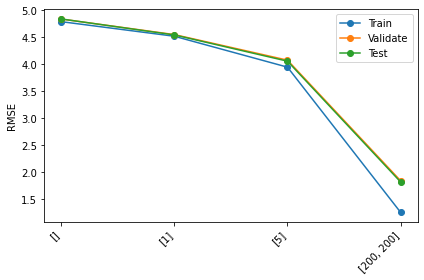

In [ ]:
plot_results(results)

For these 4 different acrhs [200,200] is by far the best arch for this data set. It has a significantly lower RMSE value than the other archs, but there is a larger differnce between the train and the test sets.

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

import time
start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[200, 200],[50,100,200],[50,50,50,50],[300,300]],
                                      1000, 0.01, 'tanh')

elapsed = (time.time() - start) / 60/ 60
print(f'Took {elapsed:.2f} hours')
results

Took 0.15 hours


,Arch,Training RMSE,Validate RMSE,Test RMSE
0,"[200, 200]",0.433623,1.629706,1.677498
1,"[50, 100, 200]",0.515800,1.468725,1.510950
2,"[50, 50, 50, 50]",0.591242,1.403789,1.400605
3,"[300, 300]",0.419588,1.685651,1.669916


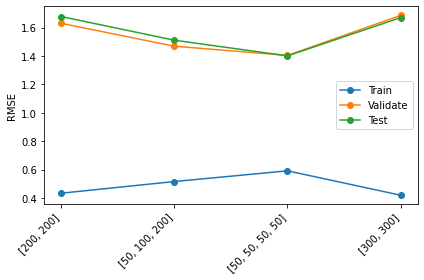

In [ ]:
plot_results(results)

For these archs we kept [200,200] as a reference to the previous set. For this set [200,200] and [300,300] had the lowest RMSE values for the train data. But [50,50,50,50] had the lowest RMSE values for the test data. Which implies that [50,50,50,50] would be a better model for this data set.


In [ ]:
torch.manual_seed(42)
np.random.seed(42)

import time
start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[200, 200],[50,100,200],[300,300]],
                                      500, 0.05, 'tanh')

elapsed = (time.time() - start) / 60/ 60
print(f'Took {elapsed:.2f} hours')
results

Took 0.06 hours


,Arch,Training RMSE,Validate RMSE,Test RMSE
0,"[200, 200]",0.910486,2.617486,2.586856
1,"[50, 100, 200]",2.148392,2.994599,2.977439
2,"[300, 300]",1.094534,2.896087,2.943870


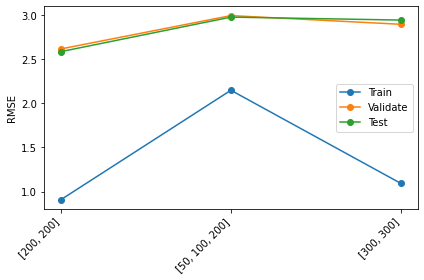

In [ ]:
plot_results(results)

For this set we are comparing the effect of changing training rate and the amount of epochs. In comparison to the previous sets the larger training rate and less epcohs resulted in a much higher RMSE values for all archs showing that there not create accurate models.

WARNING Do not run the cell bellow unless you want to wait for a while i.e. around 1.28 hours

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

import time
start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[200, 200],[50,100,200],[300,300]],
                                      10000, 0.001, 'tanh')

elapsed = (time.time() - start) / 60/ 60
print(f'Took {elapsed:.2f} hours')
results

Took 1.28 hours


,Arch,Training RMSE,Validate RMSE,Test RMSE
0,"[200, 200]",0.121118,1.741529,1.770974
1,"[50, 100, 200]",0.327569,1.599677,1.588627
2,"[300, 300]",0.127285,1.781090,1.829314


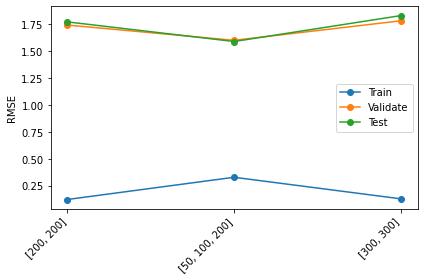

In [ ]:
plot_results(results)

For this high epoch number and low learning rate we were able to get a very low rmse value for the training data but saw no improvment with the test data set so it looks like we possible over trained our model 

# Grading and Check-In

Name your notebook as `Lastname-A3.ipynb`| with Lastname being your last name, and then save this notebook and check it in at the A3 assignment link in our Canvas web page.

# Extra Credit

Earn up to 10 extra credit points on this assignment.

1. Add a keyword argument `gpu` that is `False` by default.  If set to `True`, move data and neural network model to the GPU and train and test it there.  Compare total execution time without and with the use of the GPU.
2. Find another data set, not used previously in an assignment or in lecture, and repeat your training experiment without and with GPU on this new data.

Describe all results.

In [ ]:
def run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens, 
                                n_epochs, learning_rate, act_func, gpu=False):
    n_samples, n_inputs = X.shape
    n_outputs = T.shape[1]
    
    # Initialize the list for aggregating results
    results_list = []
    
    # Iterate over network architectures given by list_of_n_hiddens
    for network in list_of_n_hiddens:
        total_train_rmse, total_validate_rmse, total_test_rmse, total_training_sets = 0, 0, 0, 0
        
        # For each network, train on all k=fold cross-validation training sets
        for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, n_folds):
            # Increment for mean RMSE calculation later
            total_training_sets += 1
            
            # Run the netowkr with the given architecture and train on the given training set
            net = NNet(n_inputs, network, n_outputs, act_func)
            did_gpu=False
            if gpu == True:
              #print(torch.cuda.is_available())
              if torch.cuda.is_available() == True:
                net.to('cuda')
                Xtrain=torch.from_numpy(Xtrain).float().to('cuda')
                Ttrain=torch.from_numpy(Ttrain).float().to('cuda')
                Xtest=torch.from_numpy(Xtest).float().to('cuda')
                Xvalidate=torch.from_numpy(Xvalidate).float().to('cuda')
                did_gpu=True
            net.train(Xtrain, Ttrain, n_epochs, learning_rate, False)
            if did_gpu:
              Ttrain=Ttrain.cpu().numpy()
            # Calculate RMSE values for the current network/cross-validation combination
            use_train = net.use(Xtrain)
            use_validate = net.use(Xvalidate)
            use_test = net.use(Xtest)
            rmse_train = np.sqrt(np.mean((Ttrain - use_train)**2)).item()
            total_train_rmse += rmse_train
            rmse_validate = np.sqrt(np.mean((Tvalidate - use_validate)**2)).item()
            total_validate_rmse += rmse_validate
            rmse_test = np.sqrt(np.mean((Ttest - use_test)**2)).item()
            total_test_rmse += rmse_test

        mean_train_rmse = total_train_rmse / total_training_sets
        mean_validate_rmse = total_validate_rmse / total_training_sets
        mean_test_rmse = total_test_rmse / total_training_sets
        
        # Add this network's mean RMSEs to the list
        new_row = (network, mean_train_rmse, mean_validate_rmse, mean_test_rmse)
        results_list.append(new_row)

    # Add all results to a DataFrame
    column_names = ['Arch', 'Training RMSE', 'Validate RMSE', 'Test RMSE']
    df = pandas.DataFrame(results_list, columns = column_names)
    
    return df

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

import time
start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5], [200, 200, 200]],
                                      400, 0.01, 'tanh')

elapsed = (time.time() - start)
print(f'Took {elapsed:.2f} seconds')
results

start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5], [200, 200]],
                                      200, 0.01, 'tanh', True)

elapsed = (time.time() - start)
print(f'Took {elapsed:.2f} seconds')
results

Took 98.42 seconds
Took 30.44 seconds


,Arch,Training RMSE,Validate RMSE,Test RMSE
0,[],4.790863,4.830888,4.835060
1,[1],4.481736,4.534722,4.535605
2,[5],3.909025,3.978667,3.996896
3,"[200, 200]",1.282880,1.795164,1.796613


On average from the times that we have run the neural network on cpu vs gpu we are seeing a speed up of 2 to 3 times the cpu. This was slower than what was origopnaly expected, but this may be due to the quality of the gpu's that google colab provides.

This following command is to upload the DropTimes.csv to google colab. If a problem develops with the file a runtime factory reset has always fixed any problem encounted.

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving DropTimes.csv to DropTimes.csv


The DropTimes.csv contains the data of the time between a water drop and the previous drops. This was origonaly intended to determian the chaotic nature of a water droplets under different nozzle conditions, but for this instance we are using one run of data at a set nozzle size to train our network.

In [ ]:
chaotic_drop_times = pandas.read_csv('DropTimes.csv', delimiter=',',
                          names=('tn-5', 'tn-4', 
                                 'tn-3', 'tn-2', 'tn-1','tn'))
chaotic_drop_times = chaotic_drop_times.dropna()
chaotic_drop_times.isna().sum()
chaotic_drop_times

,tn-5,tn-4,tn-3,tn-2,tn-1,tn
0,2.073026,1.728606,1.381327,1.036856,0.69267,0.34702
1,2.070957,1.725747,1.381276,1.037090,0.69144,0.34442
2,2.074036,1.726486,1.382300,1.036650,0.68963,0.34521
3,2.075940,1.729850,1.384200,1.037180,0.69276,0.34755
4,2.076120,1.730290,1.383270,1.038850,0.69364,0.34609
...,...,...,...,...,...,...
13309,3.330000,2.780000,2.220000,1.670000,1.11000,0.56000
13310,3.330000,2.770000,2.220000,1.660000,1.11000,0.55000
13311,3.330000,2.780000,2.220000,1.670000,1.11000,0.56000
13312,3.330000,2.770000,2.220000,1.660000,1.11000,0.55000


In [ ]:
X = chaotic_drop_times.iloc[:,:-1].to_numpy()
Tn = chaotic_drop_times.iloc[:,-1:].to_numpy()
Tn_prime=[]
for i in range(len(X)):
  Tn_prime.append(X[i][4]) 

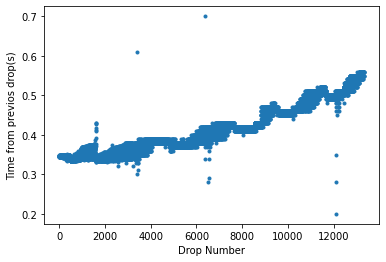

In [ ]:

plt.ylabel('Time from previos drop(s)')
plt.xlabel('Drop Number')
plt.plot(Tn, '.', label='Training Data')
plt.show()

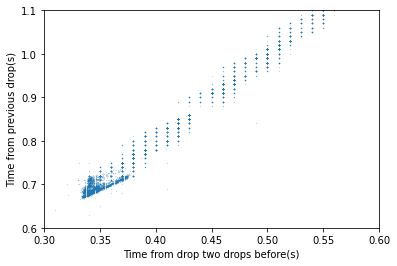

In [ ]:
plt.scatter(Tn,Tn_prime,.01)
plt.xlim(.3,.6)
plt.ylim(.6,1.1)
plt.xlabel('Time from drop two drops before(s)')
plt.ylabel('Time from previous drop(s)')
plt.show()

The previos graph was intended to show an interesting relation between drops and the previous times but plt is not showing full number of points 

In [ ]:
start = time.time()

results = run_k_fold_cross_validation(X, Tn, 5,
                                      [[], [1], [5], [200, 200]],
                                      200, 0.01, 'tanh')

elapsed = (time.time() - start)
print(f'Took {elapsed:.2f} seconds')
results

Took 196.80 seconds


,Arch,Training RMSE,Validate RMSE,Test RMSE
0,[],0.008431,0.008470,0.008437
1,[1],0.014219,0.014194,0.014281
2,[5],0.008858,0.008853,0.008837
3,"[200, 200]",0.007185,0.007344,0.007320


In [ ]:
start = time.time()

results = run_k_fold_cross_validation(X, Tn, 5,
                                      [[], [1], [5], [200, 200]],
                                      200, 0.01, 'tanh', True)

elapsed = (time.time() - start)
print(f'Took {elapsed:.2f} seconds')
results

Took 21.60 seconds


,Arch,Training RMSE,Validate RMSE,Test RMSE
0,[],0.008408,0.008340,0.008442
1,[1],0.013584,0.013571,0.013574
2,[5],0.008963,0.008950,0.008950
3,"[200, 200]",0.007213,0.007288,0.007294


For this data set we are seeing a much larger speed up with the gpu. On average we are seeing a 10-15 times speed increase. This is most likely due to the data set being around 10 times larger so it can take much more advantage of the gpu.

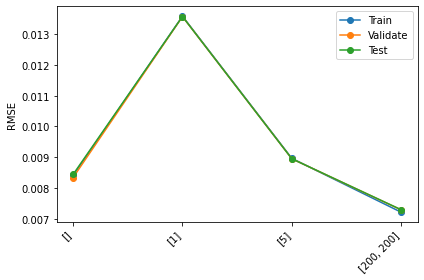

In [ ]:
plot_results(results)

From this Rmse data we can see that for this data set the Neural Network is extermly accurate for all values for hidden layers and all values. from this i feel confidant in saying that it has created a very usible model for this data set,  